In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.2 MB/s eta 0:00:00


In [2]:
!pip install Sastrawi emoji openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import emoji
from nltk.tokenize import wordpunct_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files


In [4]:
data = pd.read_excel("Data_1000.xlsx")

# === Baca file stopword ===
with open("stopwords-id.txt", "r", encoding="utf-8") as f:
    stop_words = set(f.read().splitlines())

stop_words.update([
    'aja','ya','deh','dong','sih','nih','loh','lho','toh',
    'pa','ha','kan','dll','dg','org','yg','karna','kalo',
    'nggak','ga','gak','udah','udh','nya','nyaa','krn''jadi', 'dari', 'oke', 'dengan', 'karena'
])

print(f"Jumlah stopword dimuat: {len(stop_words)} kata")

# Tampilkan beberapa baris pertama
data.head()

Jumlah stopword dimuat: 782 kata


,review
0,Harganya naik menjadi 40k krn liburan. Anak2 b...
1,Tempat wisata keluarga yang cocok juga untuk e...
2,Tempat ini bagus untuk berlibur bersama keluar...
3,Tempat ini lebih ke mini zoo ya sama spot foto...
4,Tempat mudah ditemukan karena petunjuk jalan y...


In [5]:
normalisasi_dict = {
    # singkatan umum
    'gak': 'tidak', 'ga': 'tidak', 'nggak': 'tidak', 'tdk': 'tidak',
    'yg': 'yang', 'aja': 'saja', 'tp': 'tapi', 'sm': 'sama', 'dr': 'dari',
    'sy': 'saya', 'kmu': 'kamu', 'dgn': 'dengan', 'dg': 'dengan', 'trs': 'terus',
    'udh': 'sudah', 'udah': 'sudah', 'utk': 'untuk', 'bkn': 'bukan',
    'krn': 'karena', 'karna': 'karena', 'pdhl': 'padahal', 'klo': 'kalau',
    'kl': 'kalau', 'dl': 'dulu', 'skrg': 'sekarang', 'sdh': 'sudah',
    'trnyata': 'ternyata', 'hrs': 'harus', 'jd': 'jadi', 'jg': 'juga',
    'org': 'orang', 'orgnya': 'orangnya', 'dll': '', 'pa': 'pak', 'ha': '',

    # kata gaul
    'bgt': 'banget', 'bngt': 'banget', 'btw': 'ngomong-ngomong',
    'mager': 'malas gerak', 'anjir': '', 'anjay': '', 'wkwk': '', 'wkwwk': '',
    'haha': '', 'hehe': '', 'lol': '', 'ngab': '', 'mantappp': 'mantap',

    # typo dan variasi
    'baguus': 'bagus', 'terbaikkk': 'terbaik', 'bgttt': 'banget',
    'mkn': 'makan', 'mknnya': 'makanannya', 'mankap': 'mantap'
}


In [6]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [7]:
def remove_emoji(text):
    return emoji.replace_emoji(str(text), replace='')

def preprocess_text_steps(text, hapus_angka=True):
    steps = {}
    text = str(text).lower()

    # 1️⃣ Case folding
    steps['case_folding'] = text

    # 2️⃣ Hapus emoji
    text = remove_emoji(text)
    steps['remove_emoji'] = text

    # 3️⃣ Hapus frasa khusus (misal nama tempat)
    text = re.sub(r'\bbhumi\s+merapi\b', '', text)
    steps['remove_phrase'] = text

    # 4️⃣ Hapus huruf berulang
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    steps['remove_repeated_char'] = text

    # 5️⃣ Hapus akhiran -nya dan kata 'nya' terpisah
    text = re.sub(r'\b(\w+)nya\b', r'\1', text)
    text = re.sub(r'\bnya\b', '', text)
    steps['remove_suffix_nya'] = text

    # 6️⃣ Hapus angka dan satuannya (30k, 15rb, 2jam, dst.)
    if hapus_angka:
        text = re.sub(r'\b\d+\s?(k|rb|jt|jam|menit|x)?\b', '', text)
    steps['remove_numbers'] = text

    # 7️⃣ Hapus simbol / karakter non-huruf
    text = re.sub(r'[^a-z\s]', ' ', text)
    steps['remove_nonalpha'] = text

    # 8️⃣ Tokenisasi
    tokens = wordpunct_tokenize(text)
    steps['tokenization'] = tokens

    # 9️⃣ Normalisasi (singkatan + kata gaul)
    tokens = [normalisasi_dict[w] if w in normalisasi_dict else w for w in tokens]
    tokens = [w for w in tokens if w != '']
    steps['normalization'] = tokens

    # 🔟 Stopword Removal (setelah normalisasi)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    steps['stopword_removal'] = tokens

    # 1️⃣1️⃣ Stemming
    tokens = [stemmer.stem(w) for w in tokens]
    steps['stemming'] = tokens

    # 1️⃣2️⃣ Gabungkan kembali
    cleaned_text = ' '.join(tokens)
    steps['final_text'] = cleaned_text.strip()

    return steps


In [8]:
sample = data['review'][0]
result = preprocess_text_steps(sample)


In [9]:
def preprocess_final(text):
    return preprocess_text_steps(text)['final_text']

data['cleaned_review'] = data['review'].apply(preprocess_final)

In [10]:
comparison = data[['review', 'cleaned_review']]
comparison.head(20)

,review,cleaned_review
0,Harganya naik menjadi 40k krn liburan. Anak2 b...,harga libur anak foto hewan sana spot foto bag...
1,Tempat wisata keluarga yang cocok juga untuk e...,wisata keluarga cocok edukasi anak anak sedia ...
2,Tempat ini bagus untuk berlibur bersama keluar...,bagus libur keluarga milik anak temoatbini meg...
3,Tempat ini lebih ke mini zoo ya sama spot foto...,mini zoo spot foto lumayan anak kuda kasih mak...
4,Tempat mudah ditemukan karena petunjuk jalan y...,mudah temu tunjuk jalan harga tiket mei rp par...
5,"bagus, apik, luas daerah wisatanya, kmdian ban...",bagus apik luas daerah wisata kmdian binatang ...
6,Bocil2 kesini suka banget dan betah. Banyak wa...,bocil kesini suka banget betah wahana main tam...
7,"Lokasi di Jogja utara, jalan kaliurang daerah ...",lokasi jogja utara jalan kaliurang daerah pake...
8,"Tempatnya luas, tiketnya lumayan worth it, ban...",luas tiket lumayan worth it bagus foto binatan...
9,"Suka banget dengan tempat ini, kebetulan kemar...",suka banget kemarin pas din cuaca mendung


In [11]:
data['cleaned_review'].isna().sum()
data['cleaned_review'].str.len().describe()


,cleaned_review
count,1030.000000
mean,97.548544
std,38.629926
min,10.000000
25%,68.000000
50%,97.000000
75%,125.000000
max,229.000000


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.9
)

X_tfidf = tfidf.fit_transform(data['cleaned_review'])


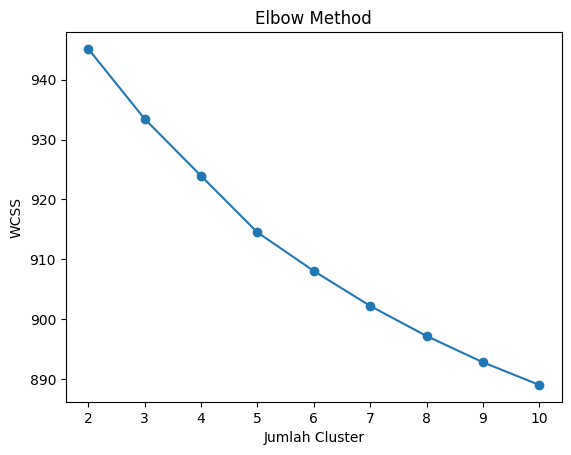

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    wcss.append(kmeans.inertia_)

plt.plot(K, wcss, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


In [14]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
data['cluster_kmeans'] = kmeans.fit_predict(X_tfidf)


In [15]:
terms = tfidf.get_feature_names_out()

for i in range(5):
    center = kmeans.cluster_centers_[i]
    top_idx = center.argsort()[-10:][::-1]
    print(f"Cluster {i}:", [terms[j] for j in top_idx])


Cluster 0: ['foto', 'spot', 'bagus', 'banget', 'kesini', 'binatang', 'pas', 'hewan', 'cocok', 'santorini']
Cluster 1: ['zoo', 'mini', 'foto', 'spot', 'anak', 'wisata', 'cocok', 'keluarga', 'bagus', 'luas']
Cluster 2: ['anak', 'hewan', 'wisata', 'cocok', 'keluarga', 'edukasi', 'banget', 'foto', 'ramah', 'tarik']
Cluster 3: ['kelinci', 'burung', 'anak', 'kambing', 'kuda', 'makan', 'kura', 'hewan', 'ular', 'rusa']
Cluster 4: ['tiket', 'masuk', 'parkir', 'orang', 'harga', 'foto', 'anak', 'luas', 'bayar', 'jangkau']


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_vec = CountVectorizer(min_df=5, max_df=0.9)
X_count = count_vec.fit_transform(data['cleaned_review'])

lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42
)

lda.fit(X_count)


LatentDirichletAllocation(n_components=5, random_state=42)

In [17]:
feature_names = count_vec.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    top_idx = topic.argsort()[-10:][::-1]
    print(f"Topik {idx}:", [feature_names[i] for i in top_idx])


Topik 0: ['foto', 'spot', 'anak', 'hewan', 'banget', 'mini', 'bagus', 'zoo', 'cocok', 'wisata']
Topik 1: ['anak', 'hewan', 'kelinci', 'cocok', 'binatang', 'kuda', 'makan', 'keluarga', 'wisata', 'kambing']
Topik 2: ['tiket', 'masuk', 'parkir', 'anak', 'orang', 'luas', 'bagus', 'foto', 'kesini', 'pas']
Topik 3: ['tiket', 'masuk', 'burung', 'hewan', 'foto', 'harga', 'kucing', 'spot', 'kelinci', 'lokasi']
Topik 4: ['wisata', 'jalan', 'rapi', 'kaliurang', 'sejuk', 'keluarga', 'salah', 'jogja', 'kota', 'lokasi']


In [18]:
# Probabilitas topik tiap dokumen
doc_topics = lda.transform(X_count)

# Ambil topik dengan probabilitas tertinggi
data['dominant_topic'] = doc_topics.argmax(axis=1)


In [19]:
print('\nContoh hasil clustering & topik:')
print(
    data[['review', 'cluster_kmeans', 'dominant_topic']].head(10)
)



Contoh hasil clustering & topik:
                                              review  cluster_kmeans  \
0  Harganya naik menjadi 40k krn liburan. Anak2 b...               0   
1  Tempat wisata keluarga yang cocok juga untuk e...               2   
2  Tempat ini bagus untuk berlibur bersama keluar...               3   
3  Tempat ini lebih ke mini zoo ya sama spot foto...               3   
4  Tempat mudah ditemukan karena petunjuk jalan y...               4   
5  bagus, apik, luas daerah wisatanya, kmdian ban...               2   
6  Bocil2 kesini suka banget dan betah. Banyak wa...               4   
7  Lokasi di Jogja utara, jalan kaliurang daerah ...               1   
8  Tempatnya luas, tiketnya lumayan worth it, ban...               0   
9  Suka banget dengan tempat ini, kebetulan kemar...               0   

   dominant_topic  
0               0  
1               0  
2               2  
3               0  
4               3  
5               4  
6               2  
7            

In [20]:
data['topic_prob'] = doc_topics.max(axis=1)


In [21]:
kolom_hasil = [
    'review',
    'cleaned_review',
    'cluster_kmeans',
    'dominant_topic'
]

data[kolom_hasil].to_excel(
    'hasil_akhir.xlsx',
    index=False
)
